In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from copy import deepcopy
from tqdm import tqdm
from scipy.stats import norm

# define the time-dependent MLP-UNet

In [3]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class MyBlock(nn.Module):
    def __init__(self, shape, out_c, block_layer):
        super(MyBlock, self).__init__()
        self.w1 = nn.Linear(shape, out_c)
        self.block_layer = block_layer
        for nl in range(2,self.block_layer+1):
            setattr(self,"w_"+str(nl),nn.Linear(out_c,out_c))
        self.activation = lambda x: x * torch.sigmoid(x)

    def forward(self, x):
        out = self.w1(x)
        out = self.activation(out)
        for nl in range(2,self.block_layer+1):
            out = self.activation(getattr(self,"w_"+str(nl))(out))
        return out

class UNet_MLP(nn.Module):
    def __init__(self, input_dim, cond_dim, cond_emb_dim = 32, time_emb_dim=32, scale = 9, block_layer = 1):
        super(UNet_MLP, self).__init__()

        # Sinusoidal embedding
        self.act = lambda x: x * torch.sigmoid(x)
        # Sinusoidal embedding
        self.time_embed = nn.Sequential(GaussianFourierProjection(embed_dim=time_emb_dim),
         nn.Linear(time_emb_dim, time_emb_dim))
        
        self.input_dim = input_dim

        self.cond_embed = MyBlock(cond_dim,cond_emb_dim,block_layer)
        self.cond_embed_dim = cond_emb_dim
        
        # First half
        first_num = 2 ** scale
        self.x_embed = MyBlock(input_dim,first_num,block_layer)
        
        self.te1 = self._make_emb(time_emb_dim, first_num)
        self.ce1 = self._make_emb(cond_emb_dim, first_num)
        self.b1 = MyBlock(first_num, first_num,block_layer)

        

        second_num = first_num // 2
        self.down1 = MyBlock(first_num,second_num,block_layer)
        
        self.te2 = self._make_emb(time_emb_dim, second_num)
        self.ce2 = self._make_emb(cond_emb_dim , second_num)
        self.b2 = MyBlock(second_num,second_num,block_layer)
    
        
        third_num = second_num // 2
        self.down2 = MyBlock(second_num,third_num,block_layer)


        # Bottleneck
        self.te_mid = self._make_emb(time_emb_dim, third_num)
        self.ce_mid = self._make_emb(cond_emb_dim, third_num)
        self.b_mid = MyBlock(third_num, third_num,block_layer)
    

        # Second half
        self.up1 = MyBlock(third_num, second_num,block_layer)

        self.te3 = self._make_emb(time_emb_dim, first_num)
        self.ce3 = self._make_emb(cond_emb_dim, first_num)
        self.b3 = MyBlock(first_num, second_num,block_layer)

        self.up2 = MyBlock(second_num, first_num,block_layer)
        self.te4 = self._make_emb(time_emb_dim, first_num * 2)
        self.ce4 = self._make_emb(cond_emb_dim, first_num * 2)
        self.b4 = MyBlock(first_num * 2, first_num,block_layer)
        

        self.final = nn.Linear(first_num, input_dim)

    def forward(self, x0, ti, xc_inp = None):
        t = self.act(self.time_embed(ti))
        x = self.x_embed(x0)
        if xc_inp is None:
            xc = torch.zeros(x.shape[0],self.cond_embed_dim).to(x.device) - 1
        else:
            xc = self.cond_embed(xc_inp)
        
        out1 = self.b1(x + self.te1(t) + self.ce1(xc))   # (N, first_num) 
        out2 = self.b2(self.down1(out1) + self.te2(t) + self.ce2(xc))    # (N, second_num)
        out_mid = self.b_mid(self.down2(out2)+ self.te_mid(t) + self.ce_mid(xc))   # (N, third_num)
        
        out3 = torch.cat((out2, self.up1(out_mid)), dim=1)  # (N, first_num)
        out4 = self.b3(out3+ self.te3(t)+ self.ce3(xc))    # (N, second)

        out5 = torch.cat((out1, self.up2(out4)), dim=1)  # (N, first_num * 2)
        out6 = self.b4(out5+ self.te4(t)+ self.ce4(xc))    # (N, first_num)

        out = self.final(out6) # (N, out)

        return out

    def _make_emb(self, dim_in, dim_out):
        return nn.Linear(dim_in, dim_out)

# Generation function

In [5]:
def ddim_sampling(model, sample_size = 100, total_steps = 50, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    interp = (1 - 2 * eps) / total_steps
    sample_points = torch.randn(sample_size,2).cuda()

    for _ in range(total_steps):
        nl = eta * np.sqrt(now_coeff - interp) 
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
        sample_points = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction + nl * torch.randn(sample_size,2).cuda()
        now_coeff -= interp

    return sample_points.cpu().numpy()


# regular sampling

In [6]:
model = UNet_MLP(data_dim, 1, 1).cuda()
model.load_state_dict(torch.load("temp_results/ddim_ema_mg.pth"))

<All keys matched successfully>

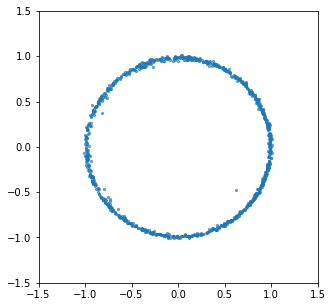

In [7]:
sample_points = ddim_sampling(model, 1000, total_steps=50, eta = 1)
plt.figure(figsize=(5,5))
plt.scatter(sample_points[:,0], sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

# sampling with proposed distribution

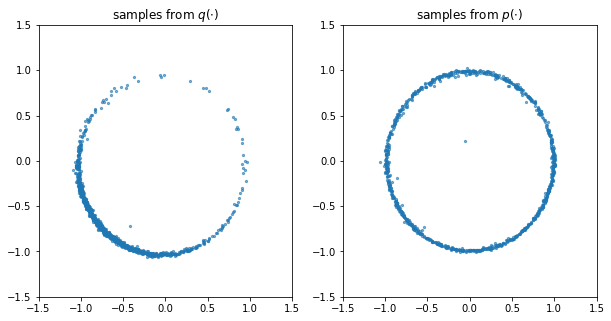

In [8]:
def ddim_proposal_sampling(model, sample_size = 100, total_steps = 50, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    interp = (1 - 2*eps) / total_steps
    sample_points = torch.randn(sample_size,2).cuda()

    for _ in range(total_steps):
        nl = eta * np.sqrt(now_coeff - interp) 
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
            direction += 0.2 + 0.2 * torch.rand_like(direction) # a deterministic bias
        sample_points = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction + nl * torch.randn(sample_size,2).cuda()
        now_coeff -= interp

    return sample_points.cpu().numpy()

proposal_sample_points = ddim_proposal_sampling(model, 1000, total_steps=50, eta = 1)
sample_points = ddim_sampling(model, 1000, total_steps=50, eta = 1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(proposal_sample_points[:,0], proposal_sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title(r"samples from $q(\cdot)$")
plt.subplot(122)
plt.scatter(sample_points[:,0], sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title(r"samples from $p(\cdot)$")
plt.show()

# The draft-refinement idea

### 1. correcting from few steps ddim

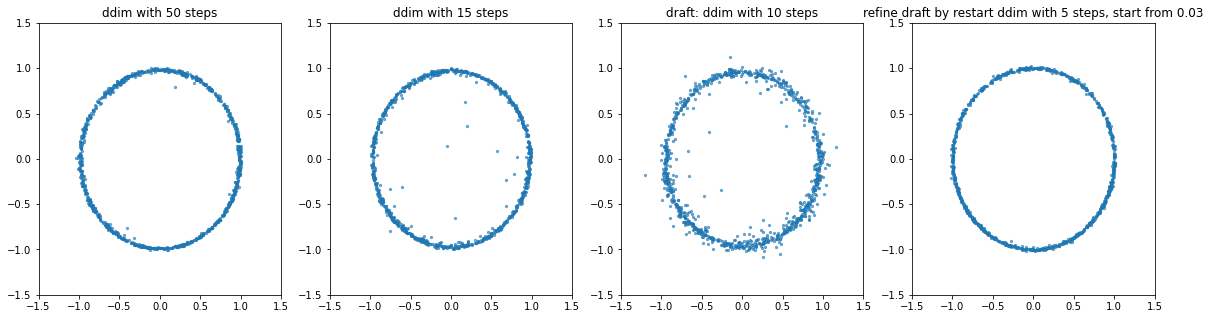

In [11]:
def ddim_sampling_from_draft(model, draft, start_coeff, total_steps = 10, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = start_coeff
    interp = (start_coeff - eps) / total_steps
    sample_points = np.sqrt(1-now_coeff) * draft + np.sqrt(now_coeff) * torch.randn_like(draft).cuda()

    for _ in range(total_steps):
        nl = eta * np.sqrt(now_coeff - interp) 
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(len(draft)).cuda() + now_coeff)
        sample_points = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction + nl * torch.randn_like(draft).cuda()
        now_coeff -= interp

    return sample_points.cpu().numpy()


ground_points = ddim_sampling(model, 1000, total_steps=50, eta = 1)
ground2_points = ddim_sampling(model, 1000, total_steps=20, eta = 1)
draft_points = ddim_sampling(model, 1000, total_steps=10, eta = 0.6)
refined_points = ddim_sampling_from_draft(model, torch.FloatTensor(draft_points).cuda(), 0.03, total_steps=5, eta = 1)
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.scatter(ground_points[:,0], ground_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title("ddim with 50 steps")
plt.subplot(142)
plt.scatter(ground2_points[:,0], ground2_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title("ddim with 15 steps")
plt.subplot(143)
plt.scatter(draft_points[:,0], draft_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title("draft: ddim with 10 steps")
plt.subplot(144)
plt.scatter(refined_points[:,0], refined_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title("refine draft by restart ddim with 5 steps, start from 0.03")
plt.show()

(-1.5, 1.5)

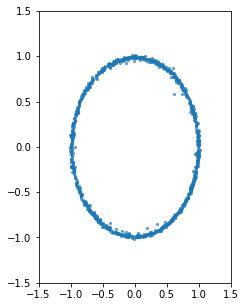

In [12]:
# compare all methods
ground_points = ddim_sampling(model, 1000, total_steps=50, eta = 1)
ground2_points = ddim_sampling(model, 1000, total_steps=20, eta = 1)
draft_points = ddim_sampling(model, 1000, total_steps=10, eta = 0.6)
refined_points = ddim_sampling_from_draft(model, torch.FloatTensor(draft_points).cuda(), 0.03, total_steps=5, eta = 1)
proposal_sample_points = ddim_proposal_sampling(model, 1000, total_steps=50, eta = 1)
plt.figure(figsize=(20,5))
plt.subplot(151)
plt.scatter(ground_points[:,0], ground_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)


### 2. correcting from a biased distribution

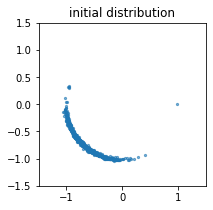

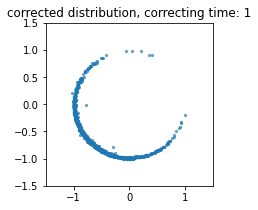

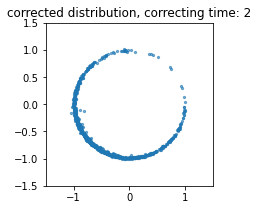

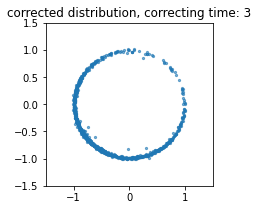

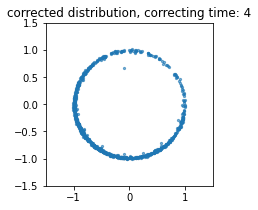

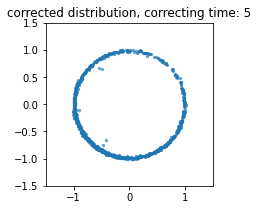

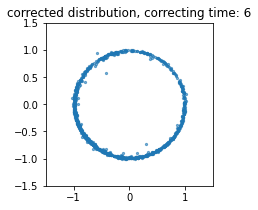

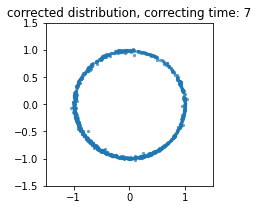

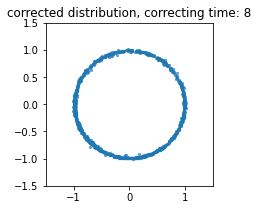

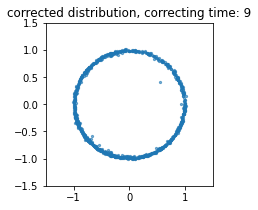

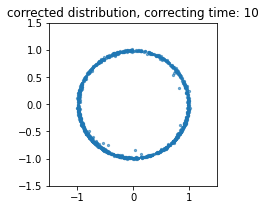

In [13]:
biased_sample_points = ddim_proposal_sampling(model, 1000, total_steps=1000, eta = 1)

plt.figure(figsize=(3,3))
plt.scatter(biased_sample_points[:,0], biased_sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title(r"initial distribution")
plt.show()

correcting_times = 10
correct_time = 0.1
correct_steps = 5
for ct in range(correcting_times):
    biased_sample_points = ddim_sampling_from_draft(model, torch.FloatTensor(biased_sample_points).cuda(), correct_time, total_steps=correct_steps, eta = 1)
    plt.figure(figsize=(3,3))
    plt.scatter(biased_sample_points[:,0], biased_sample_points[:,1], s=5, alpha=0.6)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.title(r"corrected distribution" + ", correcting time: {}".format(ct + 1))
    plt.show()